In [2]:
import pickle
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from tdamapper.core import MapperAlgorithm
from tdamapper.cover import CubicalCover
from tdamapper.plot import MapperLayoutInteractive, MapperLayoutStatic
from tdamapper.clustering import FailSafeClustering
from sklearn import metrics

from functions import *
from chi import *
from regressionP import *
from models import *

In [3]:
data1 = pd.read_csv("./Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("./Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("./Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("./Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("./Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("./Data/NPA_TMA2_6.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6], ignore_index=True)

dataA1 = pd.read_csv("./Data/NPA_TMA1_new.csv")[:-2]

In [26]:
def preprocess(input_data, select_lst):
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 7]
    dataA = sample_data[select_lst]
    
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df, sample_data

select_lst = [
    '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者',
    '道路型態大類別名稱', '事故位置大類別名稱',  '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '死亡受傷人數', '經度', '緯度',
]

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

rbind_data = pd.concat([dist_dfA1[0], dist_dfA2[0]], axis=0, ignore_index=True)

rbind_data.loc[rbind_data['受傷'] > 1, '受傷'] = 2
rbind_data['速限-第1當事者'] = rbind_data['速限-第1當事者'].apply(lambda x: 1 if x > 60 else 0)

dist_df = process_data(rbind_data)
scaler = StandardScaler()

full_dist = pd.DataFrame(scaler.fit_transform(dist_df), columns = dist_df.columns)
X1 = full_dist.drop(['受傷', '死亡', '經度', '緯度'], axis=1).to_numpy()

full_dist.head()

,光線名稱,道路類別-第1當事者-名稱,速限-第1當事者,道路型態大類別名稱,事故位置大類別名稱,號誌-號誌種類名稱,車道劃分設施-分向設施大類別名稱,車道劃分設施-分道設施-快車道或一般車道間名稱,車道劃分設施-分道設施-快慢車道間名稱,車道劃分設施-分道設施-路面邊線名稱,事故類型及型態大類別名稱,經度,緯度,死亡,受傷
0,0.123017,2.096435,-0.148895,1.213567,0.486423,-0.712247,-1.628151,1.775343,-1.706019,-0.916000,1.800087,-0.612124,-1.839571,14.069323,-2.803115
1,1.452595,-0.257342,-0.148895,-0.812716,-0.871796,2.776686,-1.628151,-0.819002,-1.706019,-0.916000,-0.025626,1.113577,0.990073,14.069323,-0.620256
2,-1.206562,2.881027,-0.148895,1.213567,1.165533,-0.712247,1.180580,1.126756,-1.706019,-0.916000,1.800087,-2.416285,-0.610402,14.069323,-2.803115
3,-1.206562,-0.257342,-0.148895,-0.812716,-0.871796,2.776686,-0.223786,-0.819002,0.423384,1.091703,-0.025626,0.940543,1.031724,14.069323,-0.620256
4,1.452595,2.096435,-0.148895,1.213567,1.165533,-0.712247,0.478397,-0.819002,0.423384,-0.916000,1.800087,1.826145,0.205783,14.069323,-2.803115


In [26]:
start_time = time.time()

lens1 = PCA(10).fit_transform(X1)

mapper_algo1 = MapperAlgorithm(
    cover = CubicalCover(
        n_intervals = 4,
        overlap_frac = 0.4
    ),
    clustering = FailSafeClustering(
        clustering = AgglomerativeClustering(3, linkage='ward'),
        verbose = False)
)

mapper_graph1 = mapper_algo1.fit_transform(X1, lens1)

end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

1373.2033610343933


In [6]:
# mapper_plot1 = MapperLayoutInteractive(
#     mapper_graph1,
#     colors = dist_df[['事故類型及型態大類別名稱']].to_numpy(),
#     cmap = 'jet',
#     # agg = np.nanmean,
#     agg = most_frequent_nonan,
#     dim = 3,
#     iterations = 30,
#     seed = 6,
#     width = 800,
#     height = 500)

In [7]:
# fig_mean1 = mapper_plot1.plot()
# fig_mean1.show(config={'scrollZoom': True})

In [100]:
# import pickle

# with open('CalculatedData/道路V2.pkl', 'wb') as f:
#     pickle.dump(mapper_graph1, f)

# 模型比較

In [4]:
def preprocess(input_data, select_lst):
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 7]
    dataA = sample_data[select_lst]
    
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df, sample_data

# List of columns to select
select_lst = [
    '天候名稱', 
    '路面狀況-路面狀態名稱',
    '肇因研判大類別名稱-主要', '當事者屬-性-別名稱', '當事者事故發生時年齡', 
    '車輛撞擊部位大類別名稱-最初',
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者', 
    '道路型態大類別名稱',
    '事故位置大類別名稱', 
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '死亡受傷人數',
    '經度', '緯度',
    '道路型態子類別名稱', '事故位置子類別名稱', '車道劃分設施-分向設施子類別名稱', '事故類型及型態子類別名稱', 
    '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位子類別名稱-其他', '肇因研判子類別名稱-個別',
    
    '當事者區分-類別-大類別名稱-車種', '當事者區分-類別-子類別名稱-車種',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃',
    '路面狀況-路面鋪裝名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱','號誌-號誌動作名稱',
]

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

rbind_data = pd.concat([dist_dfA1[0], dist_dfA2[0]], axis=0, ignore_index=True)

rbind_data.loc[rbind_data['受傷'] > 1, '受傷'] = 2
rbind_data['速限-第1當事者'] = rbind_data['速限-第1當事者'].apply(lambda x: 1 if x > 60 else 0)
rbind_data = process_age(rbind_data)
# 顏色處理
# rbind_data['color'] = rbind_data['速限-第1當事者'].astype(str) + rbind_data['事故類型及型態大類別名稱']

dist_df = process_data(rbind_data)
scaler = StandardScaler()

full_dist = pd.DataFrame(scaler.fit_transform(dist_df), columns = dist_df.columns)
X1 = full_dist.drop(['受傷', '死亡'], axis=1).to_numpy()

full_dist.head()

,天候名稱,路面狀況-路面狀態名稱,肇因研判大類別名稱-主要,當事者屬-性-別名稱,當事者事故發生時年齡,車輛撞擊部位大類別名稱-最初,光線名稱,道路類別-第1當事者-名稱,速限-第1當事者,道路型態大類別名稱,...,肇因研判大類別名稱-個別,肇事逃逸類別名稱-是否肇逃,路面狀況-路面鋪裝名稱,路面狀況-路面缺陷名稱,道路障礙-障礙物名稱,道路障礙-視距品質名稱,道路障礙-視距名稱,號誌-號誌動作名稱,死亡,受傷
0,-0.467609,-0.353119,0.507206,0.744425,-1.094758,-0.371149,0.123017,2.096435,-0.148895,1.213567,...,0.506353,-0.134302,-0.045993,-0.030455,0.000242,0.121369,0.063659,0.836165,14.069323,-2.803115
1,-0.467609,-0.353119,0.507206,0.744425,0.675067,1.176375,1.452595,-0.257342,-0.148895,-0.812716,...,0.506353,-0.134302,-0.045993,-0.030455,0.000242,0.121369,0.063659,-1.194649,14.069323,-0.620256
2,1.125243,-0.353119,0.507206,0.744425,0.675067,-0.371149,-1.206562,2.881027,-0.148895,1.213567,...,0.506353,-0.134302,-0.045993,-0.030455,0.000242,0.121369,0.063659,0.836165,14.069323,-2.803115
3,-0.467609,-0.353119,0.507206,0.744425,-0.209846,-0.371149,-1.206562,-0.257342,-0.148895,-0.812716,...,0.506353,-0.134302,-0.045993,-0.030455,0.000242,0.121369,0.063659,-1.194649,14.069323,-0.620256
4,1.125243,-0.353119,0.507206,0.744425,-1.094758,-0.371149,1.452595,2.096435,-0.148895,1.213567,...,0.506353,-0.134302,-0.045993,-0.030455,0.000242,0.121369,0.063659,0.836165,14.069323,-2.803115


In [5]:
with open('CalculatedData/道路V2.pkl', 'rb') as f:
    mapper_graph1 = pickle.load(f)
    
mapper_plot1 = MapperLayoutInteractive(
    mapper_graph1,
    colors = dist_df[['事故類型及型態大類別名稱']].to_numpy(),
    cmap = 'jet',
    # agg = np.nanmean,
    agg = most_frequent_nonan,
    dim = 3,
    iterations = 30,
    seed = 6,
    width = 800,
    height = 500)

In [14]:
# fig_mean1 = mapper_plot1.plot()
# fig_mean1.show(config={'scrollZoom': True})

In [6]:
x = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['x']
y = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['y']
z = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['z']

threeDimData = pd.DataFrame({'x': x, 'y': y, 'z': z})

import re
data_tuple = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['text']

data = []
for item in data_tuple:
    color = int(re.search(r'color: (\d+)', item).group(1))
    node = int(re.search(r'node: (\d+)', item).group(1))
    size = int(re.search(r'size: (\d+)', item).group(1))
    data.append({'color': color, 'node': node, 'size': size})
component_info = pd.DataFrame(data)

full_info = pd.concat([component_info, threeDimData], axis=1)

mp_content_origin = vars(mapper_plot1._MapperLayoutInteractive__graph)['_node']

mp_content = pd.DataFrame.from_dict(mp_content_origin, orient='index')
mp_content.reset_index(inplace=True)
mp_content.rename(columns={'index': 'node'}, inplace=True)

full_info = pd.merge(full_info, mp_content, on=['node', 'size'], how='inner')

In [7]:
calinski_data = get_calinski_from_db(full_info, 0.045)
labels = calinski_data[3]
db = calinski_data[2]
n_clusters_ = calinski_data[4]

unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# def matplotlib_to_plotly(cmap, alpha=1):
#     """rgba"""
#     return f'rgba({int(cmap[0]*200)}, {int(cmap[1]*200)}, {int(cmap[2]*200)}, {alpha})'

# colors = [matplotlib_to_plotly(plt.cm.Spectral(each), alpha=0.8) for each in np.linspace(0, 1, len(unique_labels))]
# fig = go.Figure()

# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         col = 'rgba(0,0,0,0)'

#     class_member_mask = labels == k

#     core_samples = full_info.iloc[:, 3:6][class_member_mask & core_samples_mask]
#     fig.add_trace(go.Scatter3d(
#         x=core_samples.iloc[:, 0],
#         y=core_samples.iloc[:, 1],
#         z=core_samples.iloc[:, 2],
#         mode='markers',
#         marker=dict(
#             size=6,
#             color=col,
#             opacity=0.8
#         ),
#         name=f'Cluster {k} Core'
#     ))

#     non_core_samples = full_info.iloc[:, 3:6][class_member_mask & ~core_samples_mask]
#     fig.add_trace(go.Scatter3d(
#         x=non_core_samples.iloc[:, 0],
#         y=non_core_samples.iloc[:, 1],
#         z=non_core_samples.iloc[:, 2],
#         mode='markers',
#         marker=dict(
#             size=6,
#             color=col,
#             opacity=0.5
#         ),
#         name=f'Cluster {k} Non-Core'
#     ))

# fig.update_layout(
#     title=f"Estimated number of clusters: {n_clusters_}",
#     margin=dict(l=0, r=0, b=0, t=0)
# )

# fig.show()

In [8]:
label_0 = full_info[full_info['label'] == 0]
label_1 = full_info[full_info['label'] == 1]
label_2 = full_info[full_info['label'] == 2]
label_out = full_info[(full_info['label'] != 1) & (full_info['label'] != 2) & (full_info['label'] != 0)]

count_0 = get_count_dict(label_0)
count_1 = get_count_dict(label_1)
count_2 = get_count_dict(label_2)
count_out = get_count_dict(label_out)

print(full_info['label'].unique())

full_0 = rbind_data.loc[count_0.keys()]
full_1 = rbind_data.loc[count_1.keys()]
full_2 = rbind_data.loc[count_2.keys()]

# 離群值不需要被處理
full_out = rbind_data.loc[count_out.keys()]

lst01 = list(count_0.keys() & count_1.keys())
lst02 = list(count_0.keys() & count_2.keys())
lst12 = list(count_1.keys() & count_2.keys())
lsto0 = list(count_out.keys() & count_0.keys())
lsto1 = list(count_out.keys() & count_1.keys())
lsto2 = list(count_out.keys() & count_2.keys())

# 將重複的key另外拉出進行分析，這裡drop是為了符合卡方的獨立性前提假設
full_01 = full_0.loc[lst01]
full_02 = full_0.loc[lst02]
full_12 = full_1.loc[lst12]

full_combine = pd.concat([full_01, full_02, full_12], axis=0) # full_out
full_combine = full_combine.reset_index()
full_combine = full_combine.drop_duplicates(subset='index', keep='first')
full_combine = full_combine.drop('index', axis=1)
# 去掉連接點，使分析更嚴謹
full_0 = full_0.drop(lst01 + lst02 + lsto0, errors='ignore')
full_1 = full_1.drop(lst01 + lst12 + lsto1, errors='ignore')
full_2 = full_2.drop(lst02 + lst12 + lsto2, errors='ignore')

print('01連接點數量', len(lst01))
print('02連接點數量', len(lst02))
print('12連接點數量', len(lst12))
print('o0連接點數量', len(lsto0))
print('o1連接點數量', len(lsto1))
print('o2連接點數量', len(lsto2))
print('離群值數量', full_out.shape[0])

full_combine.shape[0] + full_0.shape[0] + full_1.shape[0] + full_2.shape[0] + full_out.shape[0] == rbind_data.shape[0]

[ 0  1  2 -1]
01連接點數量 971
02連接點數量 0
12連接點數量 0
o0連接點數量 11
o1連接點數量 14
o2連接點數量 69
離群值數量 196


True

# 重疊區域

In [8]:
lstv2 = [
    '路面狀況-路面狀態名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡', 
    '車輛撞擊部位大類別名稱-最初',
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者',
    '道路型態大類別名稱',
    '事故位置大類別名稱', 
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '事故位置子類別名稱', '事故類型及型態子類別名稱', 
    '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-個別',
    '當事者區分-類別-子類別名稱-車種',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', 
    '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃',
    '號誌-號誌動作名稱'
]

In [14]:
data_origin = pd.read_csv('CalculatedData/離群比較/原始27.csv')
data_mapper = pd.read_csv('CalculatedData/離群比較/拓墣.csv')
print('原始V1/拓墣V2', pd.merge(data_origin[lstv2], rbind_data.loc[full_out.index][lstv2]).shape)
print('原始V1/拓墣V1', pd.merge(data_origin[lstv2], data_mapper[lstv2]).shape)

原始V1/拓墣V2 (49, 28)
原始V1/拓墣V1 (53, 28)


In [15]:
data_origin = pd.read_csv('CalculatedData/離群比較/原始27_V2.csv')
data_mapper = pd.read_csv('CalculatedData/離群比較/拓墣.csv')
print('原始V2/拓墣V2', pd.merge(data_origin[lstv2], rbind_data.loc[full_out.index][lstv2]).shape)
print('原始V2/拓墣V1', pd.merge(data_origin[lstv2], data_mapper[lstv2]).shape)

原始V2/拓墣V2 (39, 28)
原始V2/拓墣V1 (33, 28)


In [16]:
# rbind_data.loc[full_out.index].to_csv('CalculatedData/離群比較/拓樸V2.csv', index=False)

In [12]:
lst_logit = [
    '路面狀況-路面狀態名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡', 
    '車輛撞擊部位大類別名稱-最初',
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者',
    '道路型態大類別名稱',
    '事故位置大類別名稱', 
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '事故位置子類別名稱', '事故類型及型態子類別名稱', 
    '當事者行動狀態子類別名稱',
    '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-個別',
    '當事者區分-類別-子類別名稱-車種',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', 
    '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-其他', 
    '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃',
    '路面狀況-路面鋪裝名稱', 
    '車道劃分設施-分向設施子類別名稱',
    '道路障礙-障礙物名稱', '車輛撞擊部位子類別名稱-其他'
    
    # '號誌-號誌動作名稱', '當事者區分-類別-大類別名稱-車種', '肇因研判大類別名稱-主要' # 降低預測值
    # '道路障礙-視距名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車輛撞擊部位大類別名稱-其他' # 降低預測值
    # '道路型態子類別名稱', '路面狀況-路面缺陷名稱', '天候名稱' # 降低
]

def get_clusterN_logit(cluster_data, lst):
    scaler = StandardScaler()
    
    c0_for_lm = process_data(cluster_data)
    c0_for_lm_X = pd.DataFrame(scaler.fit_transform(c0_for_lm), columns=c0_for_lm.columns).reset_index(drop=True, inplace=False)
    # label設定
    c0_for_lm_y = cluster_data.apply(lambda row: 1 if row['死亡'] != 0 else 2, axis=1)
        
    c0_for_lm_X = c0_for_lm_X[lst]
    
    return c0_for_lm_X, c0_for_lm_y


full_combine_X, full_combine_y = get_clusterN_logit(full_combine, lst_logit)
full_0_X, full_0_y = get_clusterN_logit(full_0, lst_logit)
full_1_X, full_1_y = get_clusterN_logit(full_1, lst_logit)
full_2_X, full_2_y = get_clusterN_logit(full_2, lst_logit)

full_out_X, full_out_y = get_clusterN_logit(full_out, lst_logit) # 新增

print(full_combine_y.value_counts())
print(full_0_y.value_counts())
print(full_1_y.value_counts())
print(full_2_y.value_counts())

2    951
1     20
dtype: int64
2    156427
1       595
dtype: int64
2    6902
1      87
dtype: int64
2    3452
1      74
dtype: int64


In [10]:
matrix_combine, score_combine, cm_combine = logistic_cm_gridsearch(full_combine_X,  full_combine_y)
matrix_out, score_out, cm_out = logistic_cm_gridsearch(full_out_X,  full_out_y)
print(score_combine, score_out)

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: Conver

0.625 0.375


/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [11]:
matrix_combine

,Label,Precision,Recall,F1 Score
0,Class_0,0.666667,0.50,0.571429
1,Class_1,0.600000,0.75,0.666667


In [12]:
matrix_out

,Label,Precision,Recall,F1 Score
0,Class_0,0.000000,0.00,0.000000
1,Class_1,0.428571,0.75,0.545455


In [15]:
start_time = time.time()
# matrix_combine, score_combine, cm_combine = logistic_cm_gridsearch(full_combine_X,  full_combine_y)
matrix_0, score_0, cm_0 = logistic_cm_gridsearch(full_0_X, full_0_y)
matrix_1, score_1, cm_1 = logistic_cm_gridsearch(full_1_X, full_1_y)
matrix_2, score_2, cm_2 = logistic_cm_gridsearch(full_2_X, full_2_y)
# print(score_combine, score_0, score_1, score_2)
print(score_0, score_1, score_2)
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: Conver

0.7162921348314607 0.875 1.0
1998.25505900383


/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [16]:
print(cm_0, '\n', cm_1, '\n', cm_2)

[[114  64]
 [ 37 141]] 
 [[19  5]
 [ 1 23]] 
 [[20  0]
 [ 0 20]]


In [49]:
cm_combine = [[4, 0],[0, 4]]
cm_out = [[3, 1],[0, 4]]
cm_0 = [[114,  64], [37, 141]] 
cm_1 = [[19, 5], [1, 23]] 
cm_2 = [[20, 0], [0, 20]]
cm_origin = [[163, 82], [62, 183]]

np.savetxt('CalculatedData/V2準確資料/cm_combine.txt', cm_combine, fmt='%d')
np.savetxt('CalculatedData/V2準確資料/cm_out.txt', cm_out, fmt='%d')
np.savetxt('CalculatedData/V2準確資料/cm_0.txt', cm_0, fmt='%d')
np.savetxt('CalculatedData/V2準確資料/cm_1.txt', cm_1, fmt='%d')
np.savetxt('CalculatedData/V2準確資料/cm_2.txt', cm_2, fmt='%d')

np.savetxt('CalculatedData/V2準確資料/cm_origin.txt', cm_origin, fmt='%d')

In [17]:
print(cm_0 + cm_1 + cm_2)

[[153  69]
 [ 38 184]]


In [18]:
print(matrix_0, '\n\n', matrix_1, '\n\n', matrix_2)

     Label  Precision    Recall  F1 Score
0  Class_0   0.754967  0.640449  0.693009
1  Class_1   0.687805  0.792135  0.736292 

      Label  Precision    Recall  F1 Score
0  Class_0   0.950000  0.791667  0.863636
1  Class_1   0.821429  0.958333  0.884615 

      Label  Precision  Recall  F1 Score
0  Class_0        1.0     1.0       1.0
1  Class_1        1.0     1.0       1.0


In [19]:
conf_matrix = cm_0 + cm_1 + cm_2

y_test, y_pred = [], []
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        y_test.extend([i] * conf_matrix[i][j])
        y_pred.extend([j] * conf_matrix[i][j])

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None, zero_division=0)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Label': [f'Class_{i}' for i in range(len(precision))],
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

### Mapper logistic總平均和評估指標

In [21]:
de = np.sum(cm_0 + cm_1 + cm_2 + cm_combine + cm_out)
logit_avg_score = (np.sum(cm_0)/de)*score_0 + (np.sum(cm_1)/de)*score_1 + (np.sum(cm_2)/de)*score_2 + (np.sum(cm_combine)/de)*score_combine + (np.sum(cm_out)/de)*score_out
print(logit_avg_score)

0.765217391304348


### 原始logistic方法總平均和評估指標

In [22]:
origin_X, origin_y = get_clusterN_logit(rbind_data, lst_logit)

start_time = time.time()

matrix_origin, score_origin, cm_origin = logistic_cm_gridsearch(origin_X, origin_y)
print(score_origin)

end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

0.7061224489795919
206.4304027557373


In [24]:
print(matrix_origin, '\n\n', cm_origin)

     Label  Precision    Recall  F1 Score
0  Class_0   0.724444  0.665306  0.693617
1  Class_1   0.690566  0.746939  0.717647 

 [[163  82]
 [ 62 183]]


# SVM

In [11]:
start_time = time.time()

matrix_combine_svm, score_combine_svm, cm_combine_svm = svc_cm_with_grid_search(full_combine_X,  full_combine_y)
matrix_out_svm, score_out_svm, cm_out_svm = svc_cm_with_grid_search(full_out_X,  full_out_y)
print(score_combine_svm, score_out_svm)

end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

1.0 0.875
2.681870698928833


In [12]:
cm_combine_svm

array([[4, 0],
       [0, 4]])

In [13]:
cm_out_svm

array([[4, 0],
       [1, 3]])

In [14]:
start_time = time.time()

matrix_0_svm, score_0_svm, cm_0_svm = svc_cm_with_grid_search(full_0_X, full_0_y)
print('0')
matrix_1_svm, score_1_svm, cm_1_svm = svc_cm_with_grid_search(full_1_X, full_1_y)
print('1')
matrix_2_svm, score_2_svm, cm_2_svm = svc_cm_with_grid_search(full_2_X, full_2_y)
print('2')

print(score_0_svm, score_1_svm, score_2_svm)
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to co

0


/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



1


/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2
0.7219101123595506 0.9375 0.975
4891.341880083084


In [20]:
print(cm_0_svm, '\n', cm_1_svm, '\n', cm_2_svm)

[[115  63]
 [ 36 142]] 
 [[22  2]
 [ 1 23]] 
 [[19  1]
 [ 0 20]]


In [21]:
print(cm_0_svm + cm_1_svm + cm_2_svm)

[[156  66]
 [ 37 185]]


### Mapper svm總平均和評估指標

In [22]:
print(matrix_0_svm, '\n\n', matrix_1_svm, '\n\n', matrix_2_svm)

     Label  Precision    Recall  F1 Score
0  Class_0   0.761589  0.646067  0.699088
1  Class_1   0.692683  0.797753  0.741514 

      Label  Precision    Recall  F1 Score
0  Class_0   0.956522  0.916667  0.936170
1  Class_1   0.920000  0.958333  0.938776 

      Label  Precision  Recall  F1 Score
0  Class_0   1.000000    0.95  0.974359
1  Class_1   0.952381    1.00  0.975610


In [16]:
de = np.sum(cm_0_svm + cm_1_svm + cm_2_svm + cm_combine_svm + cm_out_svm)
logit_avg_score = (np.sum(cm_0_svm)/de)*score_0_svm + (np.sum(cm_1_svm)/de)*score_1_svm + (np.sum(cm_2_svm)/de)*score_2_svm + (np.sum(cm_combine_svm)/de)*score_combine_svm + (np.sum(cm_out_svm)/de)*score_out_svm
print(logit_avg_score)

0.7739130434782608


In [17]:
origin_X, origin_y = get_clusterN_logit(rbind_data, lst_logit)

start_time = time.time()

matrix_origin_svm, score_origin_svm, cm_origin_svm = svc_cm_with_grid_search(origin_X, origin_y)
print(score_origin_svm)

end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



0.7122448979591837
6112.937726974487


/Users/wangqiqian/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



### 原始svm方法總平均和評估指標

In [46]:
matrix_origin_svm

,Label,Precision,Recall,F1 Score
0,Class_0,0.718487,0.697959,0.708075
1,Class_1,0.706349,0.726531,0.716298


In [47]:
score_origin_svm

0.7122448979591837

In [48]:
cm_origin_svm

array([[171,  74],
       [ 67, 178]])

In [50]:
np.savetxt('CalculatedData/V2準確資料/cm_combine_svm.txt', cm_combine_svm, fmt='%d')
np.savetxt('CalculatedData/V2準確資料/cm_out_svm.txt', cm_out_svm, fmt='%d')
np.savetxt('CalculatedData/V2準確資料/cm_0_svm.txt', cm_0_svm, fmt='%d')
np.savetxt('CalculatedData/V2準確資料/cm_1_svm.txt', cm_1_svm, fmt='%d')
np.savetxt('CalculatedData/V2準確資料/cm_2_svm.txt', cm_2_svm, fmt='%d')

np.savetxt('CalculatedData/V2準確資料/cm_origin_svm.txt', cm_origin_svm, fmt='%d')

In [18]:
cm_origin_svm

array([[171,  74],
       [ 67, 178]])

In [19]:
matrix_origin_svm

,Label,Precision,Recall,F1 Score
0,Class_0,0.718487,0.697959,0.708075
1,Class_1,0.706349,0.726531,0.716298


# Get all data

In [13]:
cm_combine = np.loadtxt('CalculatedData/V2準確資料/cm_combine.txt', dtype=int)
cm_out = np.loadtxt('CalculatedData/V2準確資料/cm_out.txt', dtype=int)
cm_0 = np.loadtxt('CalculatedData/V2準確資料/cm_0.txt', dtype=int)
cm_1 = np.loadtxt('CalculatedData/V2準確資料/cm_1.txt', dtype=int)
cm_2 = np.loadtxt('CalculatedData/V2準確資料/cm_2.txt', dtype=int)
cm_origin = np.loadtxt('CalculatedData/V2準確資料/cm_origin.txt', dtype=int)

cm_combine_svm = np.loadtxt('CalculatedData/V2準確資料/cm_combine_svm.txt', dtype=int)
cm_out_svm = np.loadtxt('CalculatedData/V2準確資料/cm_out_svm.txt', dtype=int)
cm_0_svm = np.loadtxt('CalculatedData/V2準確資料/cm_0_svm.txt', dtype=int)
cm_1_svm = np.loadtxt('CalculatedData/V2準確資料/cm_1_svm.txt', dtype=int)
cm_2_svm = np.loadtxt('CalculatedData/V2準確資料/cm_2_svm.txt', dtype=int)
cm_origin_svm = np.loadtxt('CalculatedData/V2準確資料/cm_origin_svm.txt', dtype=int)

In [25]:
print(cm_origin)
print(cm_origin_svm)

[[163  82]
 [ 62 183]]
[[171  74]
 [ 67 178]]


In [17]:
mapper_logistic = cm_combine + cm_out + cm_0 + cm_1 + cm_2
mapper_svm = cm_combine_svm + cm_out_svm + cm_0_svm + cm_1_svm + cm_2_svm

In [24]:
print(mapper_svm)

[[164  66]
 [ 38 192]]


In [23]:
print(mapper_logistic)

[[160  70]
 [ 38 192]]


In [20]:
TP = mapper_logistic[0, 0]
FP = mapper_logistic[0, 1]
FN = mapper_logistic[1, 0]
TN = mapper_logistic[1, 1]

# Manually constructing the predicted and actual values based on the confusion matrix
y_true = [0] * (TP + FP) + [1] * (FN + TN)
y_pred = [0] * TP + [1] * FP + [0] * FN + [1] * TN

# Calculating the precision, recall, f1 score and accuracy using scikit-learn
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Label': [f'Class_{i}' for i in range(len(precision))],
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

metrics_df

,Label,Precision,Recall,F1 Score
0,Class_0,0.808081,0.695652,0.747664
1,Class_1,0.732824,0.834783,0.780488


In [21]:
TP = mapper_svm[0, 0]
FP = mapper_svm[0, 1]
FN = mapper_svm[1, 0]
TN = mapper_svm[1, 1]

# Manually constructing the predicted and actual values based on the confusion matrix
y_true = [0] * (TP + FP) + [1] * (FN + TN)
y_pred = [0] * TP + [1] * FP + [0] * FN + [1] * TN

# Calculating the precision, recall, f1 score and accuracy using scikit-learn
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Label': [f'Class_{i}' for i in range(len(precision))],
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

metrics_df

,Label,Precision,Recall,F1 Score
0,Class_0,0.811881,0.713043,0.759259
1,Class_1,0.744186,0.834783,0.786885


In [14]:
def get_acc(cm):
    accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
    return accuracy

score_origin = get_acc(cm_origin)
score_origin_svm = get_acc(cm_origin_svm)

In [15]:
de = np.sum(cm_0 + cm_1 + cm_2 + cm_combine + cm_out)
logit_avg_score = (np.sum(cm_0)/de)*get_acc(cm_0) + (np.sum(cm_1)/de)*get_acc(cm_1) + (np.sum(cm_2)/de)*get_acc(cm_2) + (np.sum(cm_combine)/de)*get_acc(cm_combine) + (np.sum(cm_out)/de)*get_acc(cm_out)
print(logit_avg_score)

de = np.sum(cm_0_svm + cm_1_svm + cm_2_svm + cm_combine_svm + cm_out_svm)
svm_avg_score = (np.sum(cm_0_svm)/de)*get_acc(cm_0_svm) + (np.sum(cm_1_svm)/de)*get_acc(cm_1_svm) + (np.sum(cm_2_svm)/de)*get_acc(cm_2_svm) + (np.sum(cm_combine_svm)/de)*get_acc(cm_combine_svm) + (np.sum(cm_out_svm)/de)*get_acc(cm_out_svm)
print(svm_avg_score)

0.765217391304348
0.7739130434782608


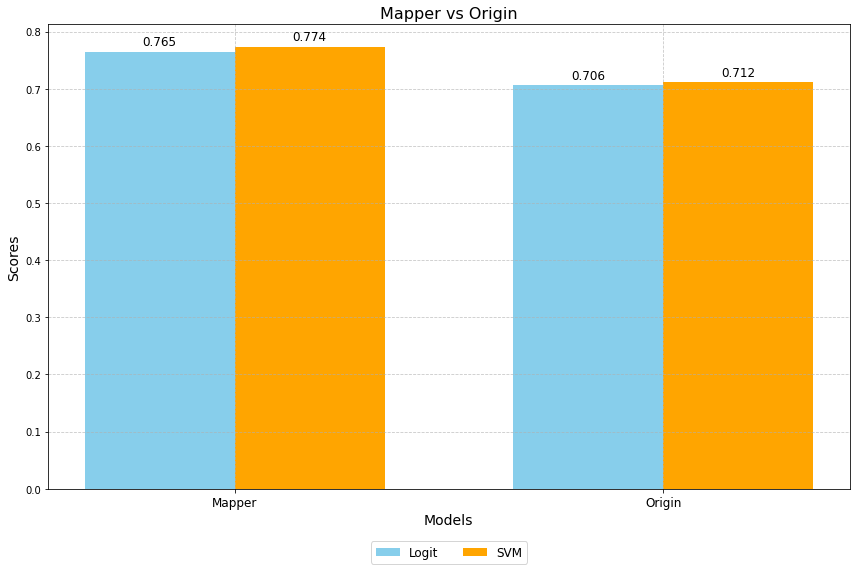

In [23]:
from matplotlib import rcParams

rcParams['font.sans-serif'] = ['DejaVu Sans']

categories = ['Mapper', 'Origin']
logit_scores = [logit_avg_score, score_origin]
svm_scores = [svm_avg_score, score_origin_svm]

x = np.arange(len(categories))
width = 0.35  

fig, ax = plt.subplots(figsize=(12, 8))  # 设置图像大小
rects1 = ax.bar(x - width/2, logit_scores, width, label='Logit', color='skyblue')
rects3 = ax.bar(x + width/2, svm_scores, width, label='SVM', color='orange')

# 添加网格线
ax.grid(True, linestyle='--', alpha=0.7)

ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Mapper vs Origin', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=12)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=12)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=12)

autolabel(rects1)
autolabel(rects3)

fig.tight_layout()

plt.show()

fig.savefig('CalculatedData/道路分析.png', bbox_inches='tight')

# 顯著特徵

In [1]:
# lst_regression = [
#     '光線名稱',
#     '道路類別-第1當事者-名稱', 
#     '速限-第1當事者', 
#     '道路型態大類別名稱', '事故位置大類別名稱',
#     '號誌-號誌種類名稱',
#     '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
#     '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
#     '事故類型及型態大類別名稱',
# ]

# X01, y01, p01 = pval(full_0, full_1, lst_regression)

# p01[p01['p_value'] < 0.05]

In [19]:
def table(colnames, full_0, full_1, full_12):
    
    combined_df = pd.concat([full_0[colnames].value_counts(normalize = True), 
                             full_1[colnames].value_counts(normalize = True),
                             full_12[colnames].value_counts(normalize = True)
                            ],
                            axis=1).fillna(0)

    combined_df.columns = ['車與車、低速線', '人與車、低速限', '車與車、高速限']
    
    return combined_df

In [43]:
table_lst = [
    # '路面狀況-路面狀態名稱',
    # '當事者屬-性-別名稱', 
    # '當事者事故發生時年齡', 
    # '車輛撞擊部位大類別名稱-最初',
    # '光線名稱',
    # '道路類別-第1當事者-名稱',1
    # '道路型態大類別名稱',
    # '事故位置大類別名稱',1
    # '號誌-號誌種類名稱',
    # '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    # '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    # '事故類型及型態大類別名稱',
    # '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', 
    # '當事者行動狀態大類別名稱',
    # '車輛撞擊部位大類別名稱-其他', 
    # '肇因研判大類別名稱-個別', 
    # '肇事逃逸類別名稱-是否肇逃',
    # '路面狀況-路面鋪裝名稱', 
    # '道路障礙-障礙物名稱',
    # '死亡'1
]
for i in table_lst:
    result = table(i, full_0, full_1, full_2)
    print(i,'\n',result)

In [27]:
chi_compare(full_0, full_1)

天候名稱 p值: 3.7423913829414446e-84 可分群
路面狀況-路面狀態名稱 p值: 1.96698856787791e-66 可分群
肇因研判大類別名稱-主要 p值: 0.0 可分群
當事者屬-性-別名稱 p值: 1.9208024450862807e-19 可分群
當事者事故發生時年齡 p值: 2.877871255650202e-119 可分群
車輛撞擊部位大類別名稱-最初 p值: 0.0 可分群
光線名稱 p值: 4.5575293150708896e-32 可分群
道路類別-第1當事者-名稱 p值: 9.896001421504978e-12 可分群
速限-第1當事者 p值: 1.0 不可分群
道路型態大類別名稱 p值: 2.3971756564178616e-118 可分群
事故位置大類別名稱 p值: 0.0 可分群
號誌-號誌種類名稱 p值: 6.400071832738002e-68 可分群
車道劃分設施-分向設施大類別名稱 p值: 3.844146913876763e-133 可分群
車道劃分設施-分道設施-快車道或一般車道間名稱 p值: 7.937562385899556e-07 可分群
車道劃分設施-分道設施-快慢車道間名稱 p值: 1.8210249862734978e-17 可分群
車道劃分設施-分道設施-路面邊線名稱 p值: 5.818908126846127e-25 可分群
事故類型及型態大類別名稱 p值: 0.0 可分群
經度 p值: 1.8109807470313417e-40 可分群
緯度 p值: 3.0842286074638883e-27 可分群
道路型態子類別名稱 p值: 3.3397421101568733e-165 可分群
事故位置子類別名稱 p值: 0.0 可分群
車道劃分設施-分向設施子類別名稱 p值: 3.546043933354523e-135 可分群
事故類型及型態子類別名稱 p值: 0.0 可分群
當事者行動狀態子類別名稱 p值: 0.0 可分群
車輛撞擊部位子類別名稱-最初 p值: 0.0 可分群
車輛撞擊部位子類別名稱-其他 p值: 0.0 可分群
肇因研判子類別名稱-個別 p值: 0.0 可分群
當事者區分-類別-大類別名稱-車種 p值: 0.0 可分群
當事者區分-類別-子類別名稱-

[]

In [28]:
chi_compare(full_0, full_2)

天候名稱 p值: 2.117077609696697e-07 可分群
路面狀況-路面狀態名稱 p值: 0.0020400827698896905 可分群
肇因研判大類別名稱-主要 p值: 1.213752308797994e-23 可分群
當事者屬-性-別名稱 p值: 4.31668075008718e-67 可分群
當事者事故發生時年齡 p值: 3.676778231078707e-33 可分群
車輛撞擊部位大類別名稱-最初 p值: 0.0 可分群
光線名稱 p值: 7.104963991197325e-09 可分群
道路類別-第1當事者-名稱 p值: 0.0 可分群
速限-第1當事者 p值: 0.0 可分群
道路型態大類別名稱 p值: 3.250294483273938e-280 可分群
事故位置大類別名稱 p值: 1.395200716288879e-306 可分群
號誌-號誌種類名稱 p值: 1.401993065361633e-60 可分群
車道劃分設施-分向設施大類別名稱 p值: 0.0 可分群
車道劃分設施-分道設施-快車道或一般車道間名稱 p值: 0.0 可分群
車道劃分設施-分道設施-快慢車道間名稱 p值: 1.3054819624004788e-69 可分群
車道劃分設施-分道設施-路面邊線名稱 p值: 0.0 可分群
事故類型及型態大類別名稱 p值: 4.982887308647495e-25 可分群
經度 p值: 0.0 可分群
緯度 p值: 0.0 可分群
道路型態子類別名稱 p值: 0.0 可分群
事故位置子類別名稱 p值: 0.0 可分群
車道劃分設施-分向設施子類別名稱 p值: 0.0 可分群
事故類型及型態子類別名稱 p值: 0.0 可分群
當事者行動狀態子類別名稱 p值: 0.0 可分群
車輛撞擊部位子類別名稱-最初 p值: 4.543735083455736e-139 可分群
車輛撞擊部位子類別名稱-其他 p值: 4.806765614303571e-124 可分群
肇因研判子類別名稱-個別 p值: 0.0 可分群
當事者區分-類別-大類別名稱-車種 p值: 0.0 可分群
當事者區分-類別-子類別名稱-車種 p值: 0.0 可分群
保護裝備名稱 p值: 0.0 可分群
行動電話或電腦或其他相類功能裝置名稱 p值: 8.4840

[]

In [29]:
chi_compare(full_1, full_2)

天候名稱 p值: 4.2916216127351034e-12 可分群
路面狀況-路面狀態名稱 p值: 1.6409963716758847e-08 可分群
肇因研判大類別名稱-主要 p值: 3.297160885604259e-234 可分群
當事者屬-性-別名稱 p值: 1.4292987327130624e-48 可分群
當事者事故發生時年齡 p值: 8.026403716927883e-88 可分群
車輛撞擊部位大類別名稱-最初 p值: 0.0 可分群
光線名稱 p值: 4.486805866522666e-23 可分群
道路類別-第1當事者-名稱 p值: 0.0 可分群
速限-第1當事者 p值: 0.0 可分群
道路型態大類別名稱 p值: 1.8876990735760174e-64 可分群
事故位置大類別名稱 p值: 6.181266777651324e-132 可分群
號誌-號誌種類名稱 p值: 1.4075867541730207e-75 可分群
車道劃分設施-分向設施大類別名稱 p值: 0.0 可分群
車道劃分設施-分道設施-快車道或一般車道間名稱 p值: 0.0 可分群
車道劃分設施-分道設施-快慢車道間名稱 p值: 2.9572893745014933e-75 可分群
車道劃分設施-分道設施-路面邊線名稱 p值: 6.259367692201811e-196 可分群
事故類型及型態大類別名稱 p值: 0.0 可分群
經度 p值: 5.422583871734164e-12 可分群
緯度 p值: 1.0169860507081644e-11 可分群
道路型態子類別名稱 p值: 2.776188174711388e-139 可分群
事故位置子類別名稱 p值: 0.0 可分群
車道劃分設施-分向設施子類別名稱 p值: 0.0 可分群
事故類型及型態子類別名稱 p值: 0.0 可分群
當事者行動狀態子類別名稱 p值: 0.0 可分群
車輛撞擊部位子類別名稱-最初 p值: 6.080493198036302e-259 可分群
車輛撞擊部位子類別名稱-其他 p值: 2.518962460677094e-49 可分群
肇因研判子類別名稱-個別 p值: 0.0 可分群
當事者區分-類別-大類別名稱-車種 p值: 0.0 可分群
當事者區分-類別-子類別名稱-車

[]